In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys 

import plotly.express as px

from dtaidistance import dtw
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn import manifold


In [3]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)

In [4]:
sys.path.append("../")

In [5]:
from utils.config import PLANT_1_PROCESSED_DATA_PATH

In [49]:
from utils.utils import (
    plot_cluster_curves,
    plot_cluster_analysis
)


In [7]:
plant_daily_curves_df = pd.read_parquet(PLANT_1_PROCESSED_DATA_PATH)

In [8]:
plant_daily_curves_df.head()

inverter_production_of_day,hour,min,inverter_10_day_136,inverter_10_day_137,inverter_10_day_138,inverter_10_day_139,inverter_10_day_140,inverter_10_day_141,inverter_10_day_142,inverter_10_day_143,inverter_10_day_144,inverter_10_day_145,inverter_10_day_146,inverter_10_day_147,inverter_10_day_148,inverter_10_day_149,inverter_10_day_150,inverter_10_day_151,inverter_10_day_152,inverter_10_day_153,inverter_10_day_154,inverter_10_day_155,inverter_10_day_156,inverter_10_day_157,inverter_10_day_158,inverter_10_day_159,inverter_10_day_160,inverter_10_day_161,inverter_10_day_162,inverter_10_day_163,inverter_10_day_164,inverter_10_day_165,inverter_10_day_166,inverter_10_day_167,inverter_10_day_168,inverter_10_day_169,inverter_11_day_136,inverter_11_day_137,inverter_11_day_138,inverter_11_day_139,inverter_11_day_140,inverter_11_day_141,inverter_11_day_142,inverter_11_day_143,inverter_11_day_144,inverter_11_day_145,inverter_11_day_146,inverter_11_day_147,inverter_11_day_148,inverter_11_day_149,inverter_11_day_150,inverter_11_day_151,inverter_11_day_152,inverter_11_day_153,inverter_11_day_154,inverter_11_day_155,inverter_11_day_156,inverter_11_day_157,inverter_11_day_158,inverter_11_day_159,inverter_11_day_160,inverter_11_day_161,inverter_11_day_162,inverter_11_day_163,inverter_11_day_164,inverter_11_day_165,inverter_11_day_166,inverter_11_day_167,inverter_11_day_168,inverter_11_day_169,inverter_12_day_136,inverter_12_day_137,inverter_12_day_138,inverter_12_day_139,inverter_12_day_140,inverter_12_day_141,inverter_12_day_142,inverter_12_day_143,inverter_12_day_144,inverter_12_day_145,inverter_12_day_146,inverter_12_day_147,inverter_12_day_148,inverter_12_day_149,inverter_12_day_150,inverter_12_day_151,inverter_12_day_152,inverter_12_day_153,inverter_12_day_154,inverter_12_day_155,inverter_12_day_156,inverter_12_day_157,inverter_12_day_158,inverter_12_day_159,inverter_12_day_160,inverter_12_day_161,inverter_12_day_162,inverter_12_day_163,inverter_12_day_164,inverter_12_day_165,...,inverter_7_day_138,inverter_7_day_139,inverter_7_day_140,inverter_7_day_141,inverter_7_day_142,inverter_7_day_143,inverter_7_day_144,inverter_7_day_145,inverter_7_day_146,inverter_7_day_147,inverter_7_day_148,inverter_7_day_149,inverter_7_day_150,inverter_7_day_151,inverter_7_day_152,inverter_7_day_153,inverter_7_day_154,inverter_7_day_155,inverter_7_day_156,inverter_7_day_157,inverter_7_day_158,inverter_7_day_159,inverter_7_day_160,inverter_7_day_161,inverter_7_day_162,inverter_7_day_163,inverter_7_day_164,inverter_7_day_165,inverter_7_day_166,inverter_7_day_167,inverter_7_day_168,inverter_7_day_169,inverter_8_day_136,inverter_8_day_137,inverter_8_day_138,inverter_8_day_139,inverter_8_day_140,inverter_8_day_141,inverter_8_day_142,inverter_8_day_143,inverter_8_day_144,inverter_8_day_145,inverter_8_day_146,inverter_8_day_147,inverter_8_day_148,inverter_8_day_149,inverter_8_day_150,inverter_8_day_151,inverter_8_day_152,inverter_8_day_153,inverter_8_day_154,inverter_8_day_155,inverter_8_day_156,inverter_8_day_157,inverter_8_day_158,inverter_8_day_159,inverter_8_day_160,inverter_8_day_161,inverter_8_day_162,inverter_8_day_163,inverter_8_day_164,inverter_8_day_165,inverter_8_day_166,inverter_8_day_167,inverter_8_day_168,inverter_8_day_169,inverter_9_day_136,inverter_9_day_137,inverter_9_day_138,inverter_9_day_139,inverter_9_day_140,inverter_9_day_141,inverter_9_day_142,inverter_9_day_143,inverter_9_day_144,inverter_9_day_145,inverter_9_day_146,inverter_9_day_147,inverter_9_day_148,inverter_9_day_149,inverter_9_day_150,inverter_9_day_151,inverter_9_day_152,inverter_9_day_153,inverter_9_day_154,inverter_9_day_155,inverter_9_day_156,inverter_9_day_157,inverter_9_day_158,inverter_9_day_159,inverter_9_day_160,inverter_9_day_161,inverter_9_day_162,inverter_9_day_163,inverter_9_day_164,inverter_9_day_165,inverter_9_day_166,inverter_9_day_167,inverter_9_day_168,inverter_9_day_169
0,5,0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,0.00000,0.0,0.000000,0.0,0.000000,0.000000

In [9]:
plant_daily_curves_df = plant_daily_curves_df.fillna(-0.1)
plant_daily_curves_df['time'] = pd.to_datetime(plant_daily_curves_df['hour'].astype(str) + ":" + plant_daily_curves_df['min'].astype(str), format='%H:%M').dt.time

In [16]:
%%time
daily_curves_array = plant_daily_curves_df.drop(['time','hour', "min"], axis=1).T.to_numpy()

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.43 ms


In [14]:
%%time

clustering_result_df = pd.DataFrame({"days_names": plant_daily_curves_df.drop(['time', 'hour', "min"], axis=1).columns})
clustering_result_df["day"] = clustering_result_df["days_names"].str.split('_', n=2).apply(lambda x: x[2])

CPU times: user 2.86 ms, sys: 1.54 ms, total: 4.4 ms
Wall time: 3.57 ms


In [17]:
%%time
distance_matrix = dtw.distance_matrix_fast(daily_curves_array, window=4)

CPU times: user 666 ms, sys: 11 ms, total: 677 ms
Wall time: 100 ms


In [67]:
#for eps in np.arange(0.1, 1.0, 0.01):
#    print(f"eps={eps}")
#    clustering = DBSCAN(eps=eps, min_samples=10, metric='precomputed')
#    clustering.fit(distance_matrix)
#    labels = clustering.labels_
#    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#    n_noise_ = list(labels).count(-1)
#    print("Estimated number of clusters: %d" % n_clusters_)
#    print("Estimated number of noise points: %d" % n_noise_)
#    print(f"Silhouette Coefficient: {metrics.silhouette_score(distance_matrix, labels):.3f}")
#    print("========================================")

In [65]:
%%time

clustering = DBSCAN(eps=0.31, min_samples=10, metric='precomputed')
clustering.fit(distance_matrix)

labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print(f"Silhouette Coefficient: {metrics.silhouette_score(distance_matrix, labels):.3f}")

Estimated number of clusters: 34
Estimated number of noise points: 45
Silhouette Coefficient: 0.555
CPU times: user 116 ms, sys: 90.3 ms, total: 206 ms
Wall time: 29.5 ms


In [25]:
%%time
clustering_result_df['clustering_labels'] = labels
clustering_result_df['clustering_labels'] = clustering_result_df['clustering_labels'].astype("category")

CPU times: user 1.25 ms, sys: 877 µs, total: 2.12 ms
Wall time: 1.52 ms


In [20]:
%%time
mds_scaling = manifold.MDS(
    n_components=2,
    max_iter=50,
    n_init=4,
    random_state=42,
    dissimilarity='precomputed'
)
s_scaling = mds_scaling.fit_transform(distance_matrix)

CPU times: user 17.9 s, sys: 13.4 s, total: 31.3 s
Wall time: 2.63 s


In [21]:
clustering_result_df['x'] = s_scaling[:, 0]
clustering_result_df['y'] = s_scaling[:, 1]

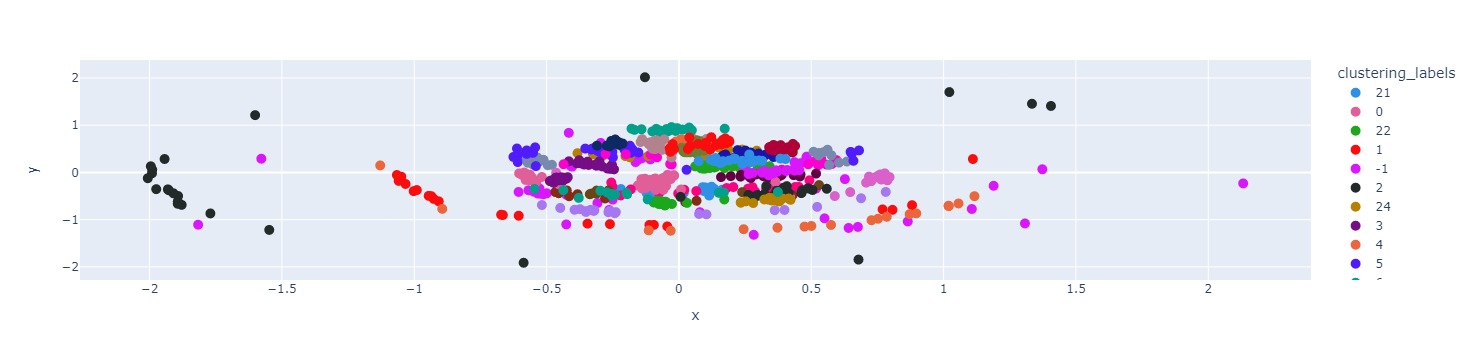

CPU times: user 150 ms, sys: 0 ns, total: 150 ms
Wall time: 146 ms


In [27]:
%%time
fig = px.scatter(clustering_result_df, y="y", x="x", color="clustering_labels", color_discrete_sequence=px.colors.qualitative.Dark24)
fig.update_traces(marker_size=10)
fig.show()

In [28]:
clustering_result_df.groupby(["clustering_labels"]).agg({"clustering_labels":["count"]})


,clustering_labels
,count
clustering_labels,
-1,45
0,44
1,22
2,22
3,20
4,21
5,20
6,21


In [30]:
%%time
for cluster in sorted(list(clustering_result_df['clustering_labels'].unique())):
    print(f"cluster ====> {cluster}")
    print(clustering_result_df[clustering_result_df['clustering_labels'] == cluster].groupby(["day"]).agg({"day":["count"]}))
    print('========================================================================')
    #plot_cluster_curves(clustering_result_df, result_df, cluster)

cluster ====> -1
          day
        count
day          
day_136     1
day_138     1
day_140     4
day_143     2
day_144     1
day_145     2
day_146     1
day_147     3
day_152    12
day_153     2
day_155     4
day_156     1
day_159     6
day_160     1
day_161     1
day_166     2
day_168     1
cluster ====> 0
          day
        count
day          
day_137    22
day_164    22
cluster ====> 1
          day
        count
day          
day_139    22
cluster ====> 2
          day
        count
day          
day_141    22
cluster ====> 3
          day
        count
day          
day_143    20
cluster ====> 4
          day
        count
day          
day_144    21
cluster ====> 5
          day
        count
day          
day_145    20
cluster ====> 6
          day
        count
day          
day_146    21
cluster ====> 7
          day
        count
day          
day_149    22
cluster ====> 8
          day
        count
day          
day_150    22
cluster ====> 9
          day
        cou

Inverters in the cluster 12 for day_159


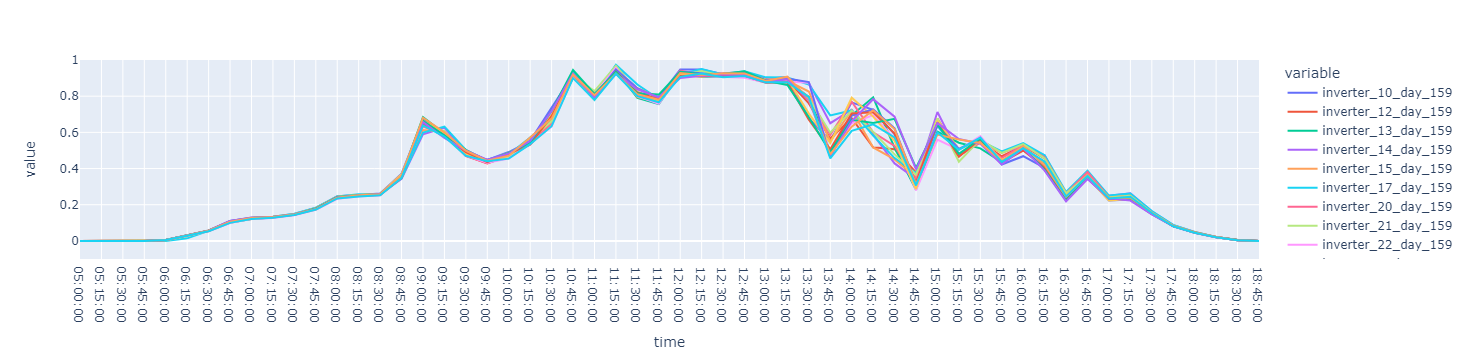

Inverters not in the cluster 12 for day_159


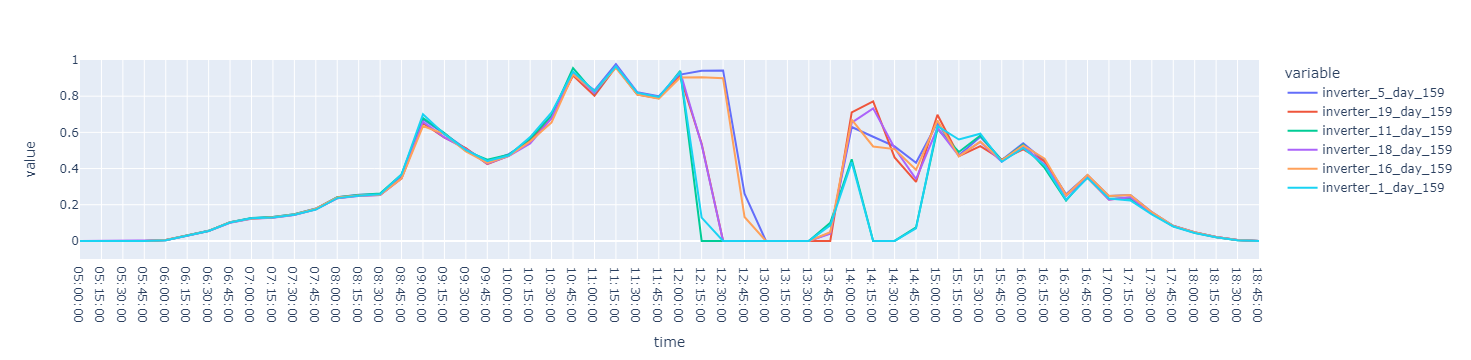

              days_names      day         x         y clustering_labels
57   inverter_11_day_159  day_159  1.307278 -1.079960                -1
227  inverter_16_day_159  day_159  1.188969 -0.282899                -1
295  inverter_18_day_159  day_159  0.282664 -1.320947                -1
329  inverter_19_day_159  day_159  1.373008  0.067303                -1
363   inverter_1_day_159  day_159 -1.577729  0.290822                -1
601   inverter_5_day_159  day_159 -0.425657 -1.101012                -1


In [54]:
cluster = 12
day = "day_159"
plot_cluster_analysis(clustering_result_df, plant_daily_curves_df, day, cluster)

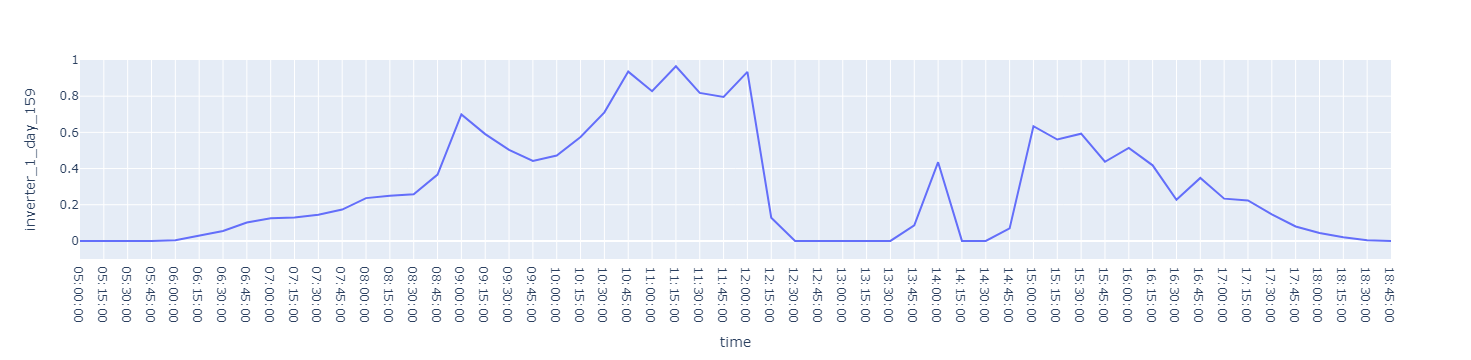

In [47]:
fig = px.line(plant_daily_curves_df, x='time', y='inverter_1_day_159', range_y=[-0.1, 1])
fig.show()

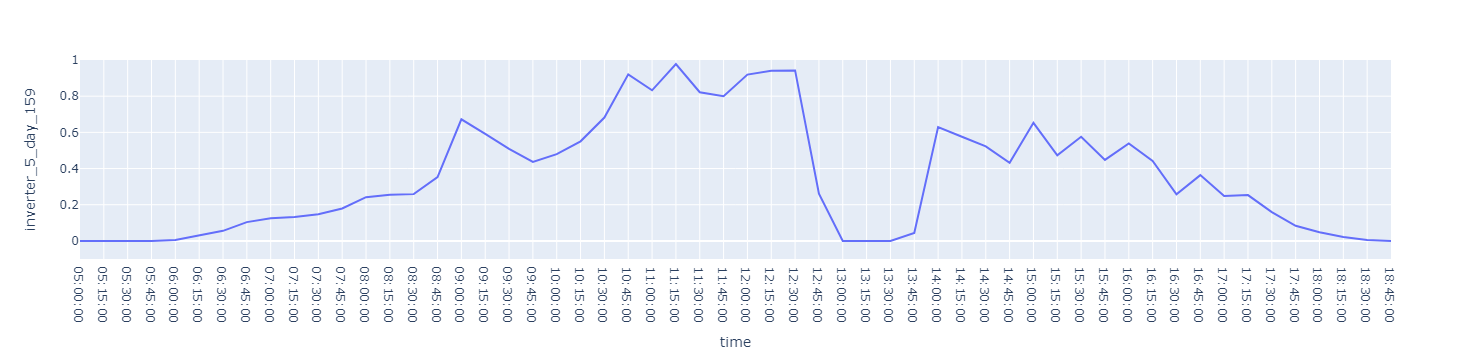

In [48]:
fig = px.line(plant_daily_curves_df, x='time', y='inverter_5_day_159', range_y=[-0.1, 1])
fig.show()

Inverters in the cluster 2 for day_141


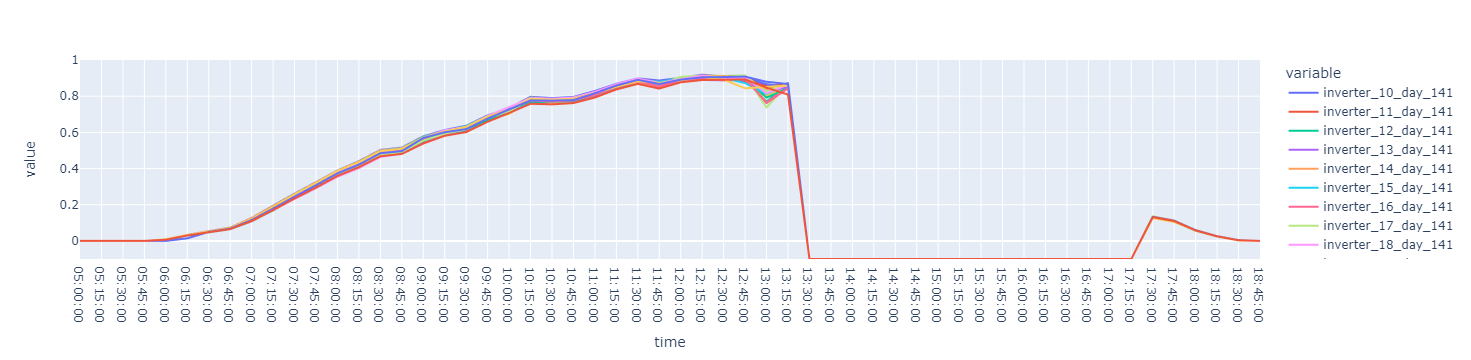

Inverters not in the cluster 2 for day_141


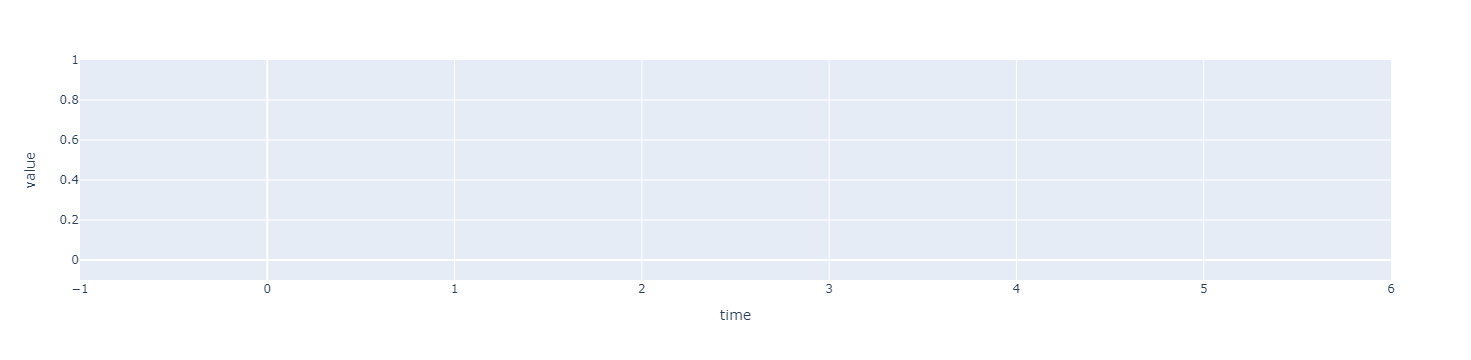

Empty DataFrame
Columns: [days_names, day, x, y, clustering_labels]
Index: []


In [55]:
cluster = 2
day = "day_141"
plot_cluster_analysis(clustering_result_df, plant_daily_curves_df, day, cluster)

Inverters in the cluster 23 for day_140


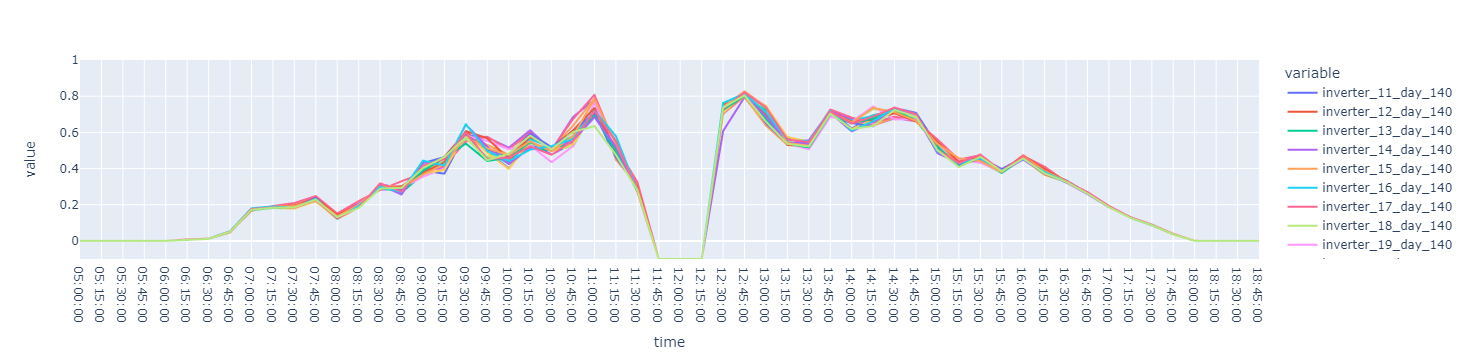

Inverters not in the cluster 23 for day_140


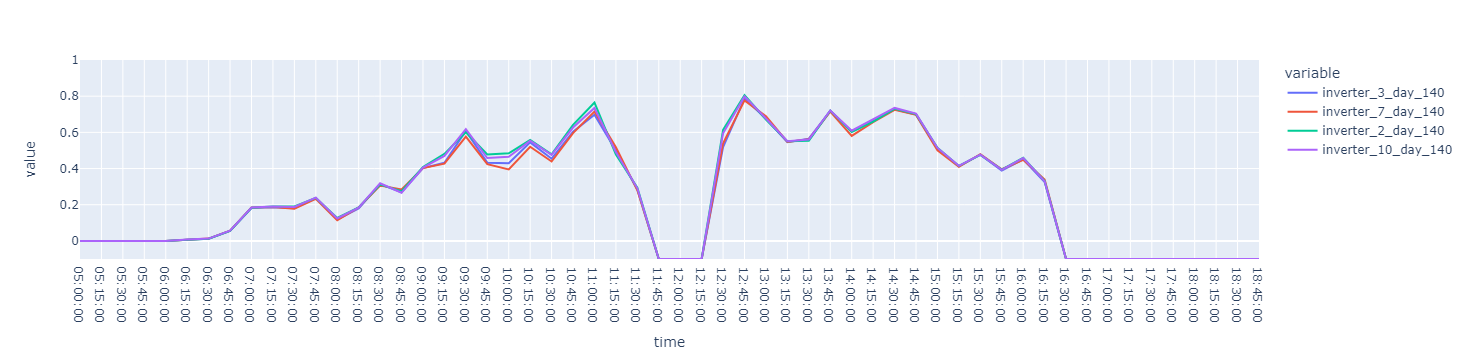

              days_names      day         x         y clustering_labels
4    inverter_10_day_140  day_140  0.641051 -1.175806                -1
480   inverter_2_day_140  day_140  0.676134 -1.153693                -1
514   inverter_3_day_140  day_140  1.106544 -0.773631                -1
650   inverter_7_day_140  day_140  0.864599 -1.038414                -1


In [56]:
cluster = 23
day = "day_140"
plot_cluster_analysis(clustering_result_df, plant_daily_curves_df, day, cluster)